In [1]:
import tweepy
import time
import ndjson
import networkx as nx
import pandas as pd

In [2]:
def check_type(tweet):
    """
    check if mention/retween/reply
    """
    fr = tweet.referenced_tweets    
    if fr is None:
        return "mentioned"
    else:
        return fr[0].type


def extract_mentions(tweet):
    if tweet.entities.get("mentions") is None:
        return []
    else:        
        return [ment.get("username") for ment in tweet.entities["mentions"] if ment.get("username") is not None]
        


def extract_user(user):
    return user.username


def extract_features(tweet):
    time = str(tweet.created_at)
    #retweet, reply,like,quote
    metric = list(tweet.public_metrics.values())
    metric = [str(_) for _ in metric]
    source = tweet.source
    metadata = [time] + metric + [source]
    return "\t".join(metadata)

In [507]:

#winter_complex "1111238619002531840"
#netscisociety 1105508110213545984
# followers_netsci = []
# i = 0
# for response in tweepy.Paginator(client.get_users_followers, "1105508110213545984", max_results=1000):
#     print(i)
#     i += 1
#     followers_netsci += [_.id for _ in response.data]
# with open("followers_netsci.txt","w+") as f:
#     for follower in followers_netsci:
#         f.write(f"{follower}\n")

0
1
2
3


In [3]:
client = tweepy.Client(open("twitter_key.key").read().strip())
name = "#ic2s2 OR #netsci OR " + " OR ".join([f"#netsci20{i}" for i in range(10,23)])
#name = "#TaxTwitter OR TaxTwitter"
print(name)

#ic2s2 OR #netsci OR #netsci2010 OR #netsci2011 OR #netsci2012 OR #netsci2013 OR #netsci2014 OR #netsci2015 OR #netsci2016 OR #netsci2017 OR #netsci2018 OR #netsci2019 OR #netsci2020 OR #netsci2021 OR #netsci2022


In [38]:

def extract_twitter_network(client, name, max_results=500, create_query=True, start="2007-05-01T12:00:01Z", print_time=True):
    if create_query:
        query = f"({name}) (lang:en) -is:nullcast -is:retweet (is:reply OR has:mentions)"
    else:
        query = name
    with open(f"data/results_{name}.tsv", "w+") as f, open(f"data/errors_{name[1:]}.ndjson","w+") as f_error:
        f.write("source\ttarget\tid\ttype\ttime\tretweet_count\treply_count\tlike_count\tquote_count\tplatform\n")
        for response in tweepy.Paginator(client, query,
                                    max_results=max_results,
                                      expansions="author_id",
                                            tweet_fields=["created_at,public_metrics,entities,source,referenced_tweets"],
                                            end_time="2022-06-01T12:00:01Z",
                                    start_time=start):
            if print_time:
                print(str(response.data[0].created_at))

            if response.includes.get("users") is None:
                return None
            
            errors = []
            for user,tweet in zip(response.includes["users"],response.data):
                try:
                    for mention in extract_mentions(tweet):
                        line = "\t".join([extract_user(user),  mention, str(tweet.id), check_type(tweet), extract_features(tweet)])
                        f.write(line+"\n")
                except:
                    t = dict(tweet)
                    if "referenced_tweets" in t:
                        del t["referenced_tweets"]
                    t["created_at"] = str(t["created_at"])
                    errors.append(t)
            ndjson.dump(errors, f_error)
            f_error.write("\n")


In [44]:
# client = tweepy.Client(open("twitter_key.key").read().strip())
# extract_twitter_network(client.search_all_tweets, "#netsci2019")
df = pd.read_csv(f"data/results_#netsci2019.tsv",sep="\t", index_col=None)
# keep active nodes (those that talk to people a bit, at least 3 times in and out)
df["year"] = df["time"].str[:4].astype(float)

G = nx.from_edgelist(df[["source","target"]].values, create_using=nx.DiGraph())
# kepe largest component (most nodes). Remove conference mentions
G.remove_nodes_from(["2019NetSci"])
Gcc = sorted(nx.connected_components(nx.Graph(G)), key=len, reverse=True)
G0 = nx.DiGraph(G.subgraph(Gcc[0]))
# remove self-mentions
G0.remove_edges_from(nx.selfloop_edges(G0))


n_nodes = len(G0)

# save to gefx
nx.write_gexf(G0, f"curated_data/netsci2019_N_{n_nodes}.gexf")


df = df.loc[df["source"].isin(Gcc[0]) & df["target"].isin(Gcc[0])].drop_duplicates()
av_degree = len(df)/n_nodes
df.to_csv(f"curated_data/ic2s2_netsci2019.tsv", sep="\t", index=None)
from collections import Counter

c = Counter(df.groupby(["source","target"])["id"].count())
print(n_nodes, av_degree, c.most_common())

202 1.4257425742574257 [(1, 288)]


In [611]:
if 0:
    #Extract query
    client = tweepy.Client(open("twitter_key.key").read().strip())
    name = "#ic2s2 OR #netsci OR " + " OR ".join([f"#netsci20{i}" for i in range(10,23)])
    extract_twitter_network(client.search_all_tweets, name)

    df = pd.read_csv(f"data/results_#ic2s2 OR #netsci OR #netsci2010 OR #netsci2011 OR #netsci2012 OR #netsci2013 OR #netsci2014 OR #netsci2015 OR #netsci2016 OR #netsci2017 OR #netsci2018 OR #netsci2019 OR #netsci2020 OR #netsci2021 OR #netsci2022.tsv",sep="\t")
    x = df["target"].value_counts()
    x = x[x>1]

    f1 = client.get_users(usernames=list(x[:100].index))
    f2 = client.get_users(usernames=list(x[100:200].index))
    f3 = client.get_users(usernames=list(x[200:300].index))
    f4 = client.get_users(usernames=list(x[300:333].index))

    with open("ids_study.txt", "w+") as f:
        for name,id_ in (zip(x.index, [_.id for _ in f1.data] + [_.id for _ in f2.data]  + [_.id for _ in f3.data]  + [_.id for _ in f4.data])):
            f.write(f"{name}\t{id_}\n")

In [5]:
ids = pd.read_csv("ids_study.txt",sep="\t",header=None)[1]

flag = 0
for id_ in ids:
    print(id_)
    if (id_ != 142995842) and (flag == 0):
        continue
    elif id_ == 142995842:
        flag = 1
        continue
    
    try:
        extract_twitter_network(client.get_users_mentions, str(id_), max_results=100, 
                            create_query=False, start="2010-11-06T00:00:00-00:00",
                            print_time=False)
    
    except:
        print("FAIL", id_)
        time.sleep(15*60)
#         pass # a couple users fail

2805421915
973642770521915394
1493423918
56341402
1979287862
700746896680161280
52354055
821654937851613186
96750943
37213193
1105508110213545984
382393
973636307774828551
582161546
833373624
27047369
16330659
490512649
35467792
796745155
103370610
20182642
426509606
2914186151
56035984
26000689
580439134
790745757527576576
21719973
529438517
75641981
833637643338526720
2147719051
373682248
1954278132
3070163032
1329752491
62621489
1344684875966771200
14065835
6758652
2329921
1167145117452570626
2332368062
2489960958
36737360
539981492
435221803
2335431
1962699368
879170334578139140
19296759
11778512
304928205
582233920
5642792
16191522
14093970
368379922
487381183
1120789424118407168
1023399072143749120
9700072
2745527973
16174144
381746423
3310650478
15045590
26419626
758039646454636548
2584784815
1324823533629841408
83392573
617118982
2882866683
14817871
373446205
572479189
255048621
956767843730649088
316738448
427309984
3729520335
21296032
18247347
15160540
272065025
4339911
29447

In [6]:
if 1:
    dfs = []
    name = "#ic2s2 OR #netsci OR " + " OR ".join([f"#netsci20{i}" for i in range(10,23)])
    dfs.append(pd.read_csv(f"data/results_{name}.tsv",sep="\t"))
    for id_ in ids:
        try:
            dfs.append(pd.read_csv(f"data/results_{id_}.tsv",sep="\t"))
        except:
            pass#rint(id_)

    df = pd.concat(dfs)
    df.to_csv("data/results_ic2s2.tsv", sep="\t")

In [2]:
def create_network(core=0,min_years=2):
    # read network
    df = pd.read_csv(f"data/results_ic2s2.tsv",sep="\t", index_col=None)
    # keep active nodes (those that talk to people a bit, at least 3 times in and out)
    df["year"] = df["time"].str[:4].astype(float)
    df["number_years"] = df.groupby("source")["year"].transform(lambda x: len(set(x)))
    # sending tweets in at least 3 years
    df = df.loc[df["number_years"]>min_years]

    G = nx.from_edgelist(df[["source","target"]].values, create_using=nx.DiGraph())
    # keep active nodes (those that talk to people a bit, at least 3 times in and out)
#     print(len(G))
    leafs = [node for node in G.nodes if (G.in_degree(node) < core) or (G.out_degree(node) < core)]
    G.remove_nodes_from(leafs)
#     print(len(G))
    # kepe largest component (most nodes)
    Gcc = sorted(nx.connected_components(nx.Graph(G)), key=len, reverse=True)
#     print(len(Gcc[0]))
    G0 = nx.DiGraph(G.subgraph(Gcc[0]))
    # remove self-mentions
    G0.remove_edges_from(nx.selfloop_edges(G0))
    
    n_nodes = len(G0)

    # save to gefx
    nx.write_gexf(G0, f"curated_data/ic2s2_netsci_CORE_{core}_N_{n_nodes}.gexf")


    df = df.loc[df["source"].isin(Gcc[0]) & df["target"].isin(Gcc[0])].drop_duplicates()
    av_degree = len(df)/n_nodes
    df.to_csv(f"curated_data/ic2s2_netsci_{core}.tsv", sep="\t", index=None)
    from collections import Counter

    c = Counter(df.groupby(["source","target"])["id"].count())
#   
    # df.tail()
    return n_nodes, av_degree, c.most_common(5)

In [3]:
for core in [150]:#list(range(11))+[20,30,40,50,60,70,80,90,100]:
    print(core, create_network(core))

150 (39, 99.05128205128206, [(1, 308), (2, 165), (3, 136), (4, 106), (5, 74)])


In [31]:
d = pd.read_csv("curated_data/ic2s2_netsci_50.tsv")
Counter(list(d["source"].values) + list(d["target"].values)).most_common()

[('manlius84', 836),
 ('svscarpino', 796),
 ('LHDnets', 635),
 ('tiagopeixoto', 628),
 ('fede7j', 610),
 ('HirokiSayama', 568),
 ('lordgrilo', 563),
 ('cosnet_bifi', 524),
 ('_jgyou', 441),
 ('dinacmistry', 432),
 ('juniperlov', 429),
 ('PiratePeel', 397),
 ('tinaeliassi', 394),
 ('all_are', 387),
 ('alexvespi', 380),
 ('aliceschwarze', 364),
 ('uvmcomplexity', 355),
 ('_leotrs', 353),
 ('MassimoSt', 351),
 ('branmorrighan', 349),
 ('GuidoCaldarelli', 332),
 ('jkbren', 328),
 ('Shugars', 317),
 ('pholme', 313),
 ('ryanjgallag', 304),
 ('DanLarremore', 296),
 ('netsci2020', 293),
 ('ciro', 290),
 ('estebanmoro', 281),
 ('foucaultwelles', 281),
 ('NUnetsi', 278),
 ('alainbarrat', 273),
 ('mtizzoni', 270),
 ('a_baronca', 265),
 ('robysinatra', 263),
 ('vcolizza', 253),
 ('dashunwang', 253),
 ('barabasi', 252),
 ('davidlazer', 242),
 ('peterdodds', 242),
 ('aaronclauset', 235),
 ('lajello', 218),
 ('net_science', 210),
 ('sfiscience', 209),
 ('iacopoiacopini', 199),
 ('mszll', 199),
 ('leo

In [26]:
df = pd.read_csv(f"data/results_netsci OR #netsci2010 OR #netsci2011 OR #netsci2012 OR #netsci2013 OR #netsci2014 OR #netsci2015 OR #netsci2016 OR #netsci2017 OR #netsci2018 OR #netsci2019 OR #netsci2020 OR #netsci2021 OR #netsci2022.tsv",sep="\t")
df["year"] = df["time"].str[:4].astype(float)
df = df.loc[df["year"]==2019]
G = nx.from_edgelist(df[["source","target"]].values, create_using=nx.DiGraph())
Gcc = sorted(nx.connected_components(nx.Graph(G)), key=len, reverse=True)
print(len(Gcc[0]))
G0 = nx.DiGraph(G.subgraph(Gcc[0]))
G0.remove_edges_from(nx.selfloop_edges(G0))
print(len(G0))

print(df.loc[df["source"].isin(Gcc[0]) & df["target"].isin(Gcc[0])].drop_duplicates().shape)

# save to gefx
nx.write_gexf(G0, "netsci2019.gexf")

288
288
(427, 11)


959
50
49
49
(131, 10)


,source,target,id,type,time,retweet_count,reply_count,like_count,quote_count,platform
1650,eric_andersen,graphcommons,215458817964654592,mentioned,2012-06-20 14:59:19+00:00,0,1,0,0,Twitter Web Client
1651,takashiiba,icouzin,215454559210962944,mentioned,2012-06-20 14:42:24+00:00,4,1,3,0,Twitter for Mac
1652,dashunwang,amaral,215447007769276416,mentioned,2012-06-20 14:12:24+00:00,0,0,0,0,Twitter Web Client
1653,ChrisDiehl,gcaprio,215444703452205057,replied_to,2012-06-20 14:03:14+00:00,0,0,0,0,Twitter for iPad
1654,ChrisDiehl,pholme,215444703452205057,replied_to,2012-06-20 14:03:14+00:00,0,0,0,0,Twitter for iPad


In [10]:
df["year"] = df["time"].str[:4].astype(float)
df["year"].value_counts().sort_index()

2011.0      107
2012.0       69
2013.0      139
2014.0      514
2015.0     1672
2016.0     1397
2017.0     2552
2018.0     8250
2019.0    14223
2020.0    35217
2021.0    51613
2022.0    54201
Name: year, dtype: int64

36062
2789
2784
2784


In [12]:
df.loc[df["source"].isin(Gcc[0]) & df["target"].isin(Gcc[0])].drop_duplicates().shape

(169907, 12)

In [13]:
df.groupby(["source","target"])["id"].count().max()

24

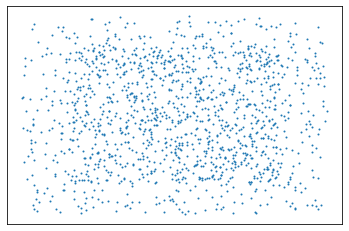

In [558]:
pos = nx.spring_layout(G0, iterations=1)
nx.draw_networkx_nodes(G0, pos = pos, node_size=1)#, edge_color="lightgray")

In [559]:
len(G0)

1357

In [413]:
df.groupby(["source","id"]).count()["target"].sort_values()

source          id           
1GreenwichGirl  YINSedge         1
iyadrahwan      PhilipLeifeld    1
                dashunwang       1
                davidlazer       1
                moorejh          1
                                ..
wetuad          Ognyanova        2
martonolbei     barabasi         2
neo4j           barabasi         2
anduviera       barabasi         3
manlius84       Ognyanova        3
Name: target, Length: 2529, dtype: int64

In [411]:
pd.DataFrame.from_dict(nx.pagerank(G), orient="index").sort_values(by=0, ascending=False).head(20)

,0
Ognyanova,0.062052
barabasi,0.061146
moorejh,0.042790
cosnet_bifi,0.033615
neesjanvaneck,0.024690
artistJaneAdams,0.022365
schichmax,0.020791
CUDANLab,0.019107
sinanaral,0.018647
BarabasiLab,0.017093


In [395]:
pd.DataFrame.from_dict?
